In [1]:
import argparse
import scipy
from scipy import ndimage
import numpy as np
import sys

import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
from torch.utils import data, model_zoo
# from model.deeplab_multi import Res_Deeplab
from model.deeplab_single import Res_Deeplab

from dataset.cityscapes_dataset import cityscapesDataSet
from collections import OrderedDict
import os
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn as nn
from dataset.gta5_dataset import GTA5DataSet



# config

In [2]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

MODEL = 'DeepLab'
BATCH_SIZE = 1
ITER_SIZE = 1
NUM_WORKERS = 4
DATA_DIRECTORY = './data/GTA5'
DATA_LIST_PATH = './dataset/gta5_list/train.txt'
IGNORE_LABEL = 255
INPUT_SIZE = '1280,720'
DATA_DIRECTORY_TARGET = './data/Cityscapes/data'
DATA_LIST_PATH_TARGET = './dataset/cityscapes_list/train.txt'
INPUT_SIZE_TARGET = '1024,512'
LEARNING_RATE = 2.5e-4
MOMENTUM = 0.9
NUM_CLASSES = 19
NUM_STEPS = 250000
NUM_STEPS_STOP = 100000  # early stopping
POWER = 0.9
RANDOM_SEED = 1234
RESTORE_FROM = 'http://vllab.ucmerced.edu/ytsai/CVPR18/DeepLab_resnet_pretrained_init-f81d91e8.pth'
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 5000
SNAPSHOT_DIR = './snapshots/'
WEIGHT_DECAY = 0.0005

LEARNING_RATE_D = 1e-4
LAMBDA_SEG = 0.1
LAMBDA_ADV_TARGET1 = 0.0002
LAMBDA_ADV_TARGET2 = 0.001

TARGET = 'cityscapes'
SET = 'train'
palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]

In [3]:
def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

# set arg parser

In [4]:
def set_arguments(args):
    """Parse all the arguments provided from the CLI.

    Returns:
      A list of parsed arguments.
    """
    parser = argparse.ArgumentParser(description="DeepLab-ResNet Network")
    parser.add_argument("--data-dir", type=str, default=DATA_DIRECTORY,
                        help="Path to the directory containing the Cityscapes dataset.")
    parser.add_argument("--data-dir-target", type=str, default=DATA_DIRECTORY_TARGET,
                        help="Path to the directory containing the target dataset.")
    parser.add_argument("--data-list", type=str, default=DATA_LIST_PATH,
                        help="Path to the file listing the images in the dataset.")
    parser.add_argument("--model", type=str, default=MODEL,
                        help="available options : DeepLab")
    parser.add_argument("--target", type=str, default=TARGET,
                        help="available options : cityscapes")
    parser.add_argument("--batch-size", type=int, default=BATCH_SIZE,
                        help="Number of images sent to the network in one step.")
    parser.add_argument("--iter-size", type=int, default=ITER_SIZE,
                        help="Accumulate gradients for ITER_SIZE iterations.")
    parser.add_argument("--num-workers", type=int, default=NUM_WORKERS,
                        help="number of workers for multithread dataloading.")
    parser.add_argument("--ignore-label", type=int, default=IGNORE_LABEL,
                        help="The index of the label to ignore during the training.")
    parser.add_argument("--input-size", type=str, default=INPUT_SIZE,
                        help="Comma-separated string with height and width of source images.")
    parser.add_argument("--data-list-target", type=str, default=DATA_LIST_PATH_TARGET,
                        help="Path to the file listing the images in the target dataset.")
    parser.add_argument("--input-size-target", type=str, default=INPUT_SIZE_TARGET,
                        help="Comma-separated string with height and width of target images.")
    parser.add_argument("--is-training", action="store_true",
                        help="Whether to updates the running means and variances during the training.")
    parser.add_argument("--learning-rate", type=float, default=LEARNING_RATE,
                        help="Base learning rate for training with polynomial decay.")
    parser.add_argument("--learning-rate-D", type=float, default=LEARNING_RATE_D,
                        help="Base learning rate for discriminator.")
    parser.add_argument("--lambda-seg", type=float, default=LAMBDA_SEG,
                        help="lambda_seg.")
    parser.add_argument("--lambda-adv-target1", type=float, default=LAMBDA_ADV_TARGET1,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--lambda-adv-target2", type=float, default=LAMBDA_ADV_TARGET2,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--momentum", type=float, default=MOMENTUM,
                        help="Momentum component of the optimiser.")
    parser.add_argument("--not-restore-last", action="store_true",
                        help="Whether to not restore last (FC) layers.")
    parser.add_argument("--num-classes", type=int, default=NUM_CLASSES,
                        help="Number of classes to predict (including background).")
    parser.add_argument("--num-steps", type=int, default=NUM_STEPS,
                        help="Number of training steps.")
    parser.add_argument("--num-steps-stop", type=int, default=NUM_STEPS_STOP,
                        help="Number of training steps for early stopping.")
    parser.add_argument("--power", type=float, default=POWER,
                        help="Decay parameter to compute the learning rate.")
    parser.add_argument("--random-mirror", action="store_true",
                        help="Whether to randomly mirror the inputs during the training.")
    parser.add_argument("--random-scale", action="store_true",
                        help="Whether to randomly scale the inputs during the training.")
    parser.add_argument("--random-seed", type=int, default=RANDOM_SEED,
                        help="Random seed to have reproducible results.")
    parser.add_argument("--restore-from", type=str, default=RESTORE_FROM,
                        help="Where restore model parameters from.")
    parser.add_argument("--save-num-images", type=int, default=SAVE_NUM_IMAGES,
                        help="How many images to save.")
    parser.add_argument("--save-pred-every", type=int, default=SAVE_PRED_EVERY,
                        help="Save summaries and checkpoint every often.")
    parser.add_argument("--snapshot-dir", type=str, default=SNAPSHOT_DIR,
                        help="Where to save snapshots of the model.")
    parser.add_argument("--weight-decay", type=float, default=WEIGHT_DECAY,
                        help="Regularisation parameter for L2-loss.")
    parser.add_argument("--gpu", type=int, default=0,
                        help="choose gpu device.")
    parser.add_argument("--set", type=str, default=SET,
                        help="choose adaptation set.")
    return parser.parse_args(args)


In [5]:
args = set_arguments("--restore-from E:/AdaptionSeg-v31-20180807-single-DA-sp-fastphoto-45k-acc-43/snapshots/GTA2Cityscapes_multi/GTA5_45000.pth --snapshot-dir ./snapshots/GTA2Cityscapes_multi --lambda-seg 0.1 --lambda-adv-target1 0.0002 --lambda-adv-target2 0.001".split(' '))

In [6]:
args

Namespace(batch_size=1, data_dir='./data/GTA5', data_dir_target='./data/Cityscapes/data', data_list='./dataset/gta5_list/train.txt', data_list_target='./dataset/cityscapes_list/train.txt', gpu=0, ignore_label=255, input_size='1280,720', input_size_target='1024,512', is_training=False, iter_size=1, lambda_adv_target1=0.0002, lambda_adv_target2=0.001, lambda_seg=0.1, learning_rate=0.00025, learning_rate_D=0.0001, model='DeepLab', momentum=0.9, not_restore_last=False, num_classes=19, num_steps=250000, num_steps_stop=100000, num_workers=4, power=0.9, random_mirror=False, random_scale=False, random_seed=1234, restore_from='E:/AdaptionSeg-v31-20180807-single-DA-sp-fastphoto-45k-acc-43/snapshots/GTA2Cityscapes_multi/GTA5_45000.pth', save_num_images=2, save_pred_every=5000, set='train', snapshot_dir='./snapshots/GTA2Cityscapes_multi', target='cityscapes', weight_decay=0.0005)

# input and resize setting

In [7]:
input_size = (1280, 720)
input_size_target = (1024,512)
interp = nn.Upsample(size=(input_size[1], input_size[0]), align_corners=False, mode='nearest')
interp_target = nn.Upsample(size=(input_size_target[1], input_size_target[0]), mode='nearest')
interp_down = nn.Upsample(size=(input_size_target[1]/4, input_size_target[0]/4), mode='nearest')


# deeplab model

In [8]:
"""Create the model and start the evaluation process."""
gpu0 = args.gpu

In [9]:
model = Res_Deeplab(num_classes=args.num_classes)

if args.restore_from[:4] == 'http' :
    saved_state_dict = model_zoo.load_url(args.restore_from)
else:
    saved_state_dict = torch.load(args.restore_from)
model.load_state_dict(saved_state_dict)

model.eval()
model.cuda(gpu0)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

# loading data

In [10]:
trainloader = data.DataLoader(
    GTA5DataSet(args.data_dir, args.data_list, max_iters=args.num_steps * args.iter_size * args.batch_size,
                crop_size=input_size,
                scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN),
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)


In [11]:
args.data_list

'./dataset/gta5_list/train.txt'

In [12]:
targetloader = data.DataLoader(cityscapesDataSet(args.data_dir_target, args.data_list_target,
                                                     max_iters=args.num_steps * args.iter_size * args.batch_size,
                                                     crop_size=input_size_target,
                                                     scale=False, mirror=args.random_mirror, mean=IMG_MEAN,
                                                     set=args.set),
                                   batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers,
                                   pin_memory=True)

In [13]:
trainloader_gen = enumerate(trainloader)
targetloader_gen = enumerate(targetloader)

# trainer source input shape

In [14]:
index, batch = next(trainloader_gen)

In [15]:
images, labels, _, name = batch
images = Variable(images).cuda(args.gpu)

In [43]:
labels.shape

torch.Size([1, 720, 1280])

In [23]:
Img = labels[:, :]

In [24]:
Img

tensor([[[ 10.,  10.,  10.,  ...,  10.,  10.,  10.],
         [ 10.,  10.,  10.,  ...,  10.,  10.,  10.],
         [ 10.,  10.,  10.,  ...,  10.,  10.,  10.],
         ...,
         [  0.,   0.,   0.,  ..., 255., 255., 255.],
         [  0.,   0.,   0.,  ..., 255., 255., 255.],
         [  0.,   0.,   0.,  ..., 255., 255., 255.]]])

In [19]:
import torchvision.transforms as transforms

In [73]:
import torchvision.transforms.functional as F

In [20]:
pilTrans = transforms.ToPILImage()

In [27]:
pilImg = pilTrans(Img/255)

In [159]:
#  get boundary map from instance map
def label_get_edges(t):
    edge = torch.cuda.ByteTensor(t.size()).zero_()
    print("edge shape", edge.shape)
    edge[:,:,:,1:] = edge[:,:,:,1:] | (t[:,:,:,1:] != t[:,:,:,:-1])
    edge[:,:,:,:-1] = edge[:,:,:,:-1] | (t[:,:,:,1:] != t[:,:,:,:-1])
    edge[:,:,1:,:] = edge[:,:,1:,:] | (t[:,:,1:,:] != t[:,:,:-1,:])
    edge[:,:,:-1,:] = edge[:,:,:-1,:] | (t[:,:,1:,:] != t[:,:,:-1,:])
    return edge.float()

In [160]:
cuda_label = Variable(labels).cuda(args.gpu)

In [161]:
label_edges = label_get_edges(cuda_label.view([1, labels.shape[0], labels.shape[1], labels.shape[2]]))

edge shape torch.Size([1, 1, 720, 1280])


In [162]:
label_edges

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [184]:
def tensor_to_PIL(tensor):
    pilTrans = transforms.ToPILImage()
    image = pilTrans(tensor.cpu().squeeze(0))
    return image

In [185]:
a = tensor_to_PIL(label_edges)

In [186]:
a.show()

In [166]:
a.save("a.png")

In [ ]:
pilTrans = transforms.ToPILImage()
pilImg = pilTrans(Img)

In [121]:
label_edges

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.uint8)

In [137]:
pilTransTensor = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])


In [145]:
test = label_edges.squeeze().cpu().numpy()

In [146]:
test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

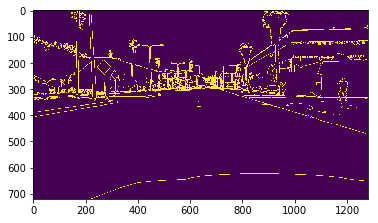

In [147]:
imgplot = plt.imshow(test)

In [149]:
img_pil = transforms.ToPILImage()(test[0])


TypeError: pic should be Tensor or ndarray. Got <class 'numpy.ndarray'>.

In [134]:
pilImg = pilTransTensor(label_edges.cpu().numpy())

TypeError: pic should be PIL Image or ndarray. Got <class 'numpy.ndarray'>

In [133]:
pilImg = pilTransTensor(label_edges)


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [115]:
pilImg.height

720

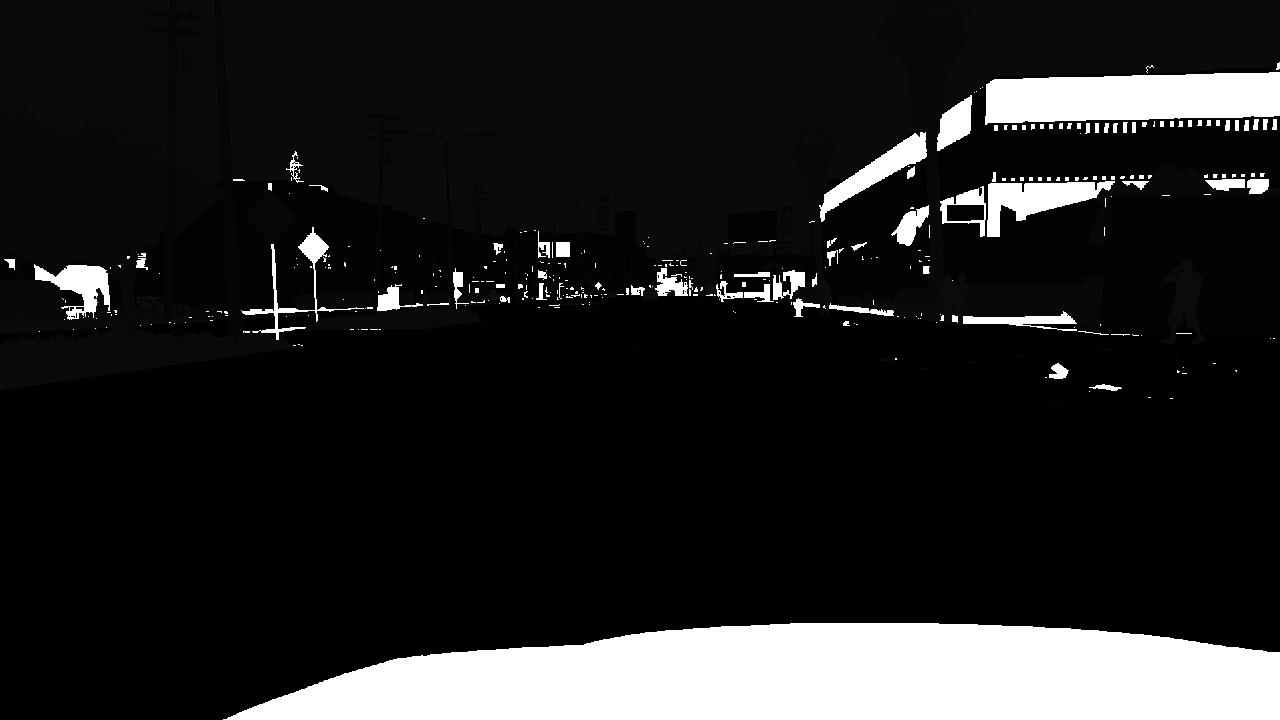

In [28]:
pilImg

In [100]:
with torch.no_grad():
    output = model(images)

In [101]:
output.shape

torch.Size([1, 19, 91, 161])

In [102]:
interp = nn.Upsample(size=(1024, 2048), mode='bilinear')
output = interp(output).permute(0, 2, 3, 1)
_, output = torch.max(output, -1)

c:\users\viplab\anaconda3\envs\xiao\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
c:\users\viplab\anaconda3\envs\xiao\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [103]:
weakly_map = {"0":0, "1":1, "2":2, "8":8, "10":10, "11":11}

In [104]:
num_classes = 19
weakly_map = [0, 1, 2, 8, 10, 11]
filter_weakly_map = set(range(num_classes)) - set(weakly_map)

In [105]:
filter_weakly_map

{3, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18}

In [106]:
test = output

In [107]:
output

tensor([[[ 5,  5,  5,  ...,  8,  8,  8],
         [ 5,  5,  5,  ...,  8,  8,  8],
         [ 5,  5,  5,  ...,  8,  8,  8],
         ...,
         [ 0,  0,  0,  ..., 13, 13, 13],
         [ 0,  0,  0,  ..., 13, 13, 13],
         [ 0,  0,  0,  ..., 13, 13, 13]]], device='cuda:0')

In [108]:
# target_mask = torch.zeros_like(test)
for value in filter_weakly_map:
    test[test==value] = 255
#     target_mask = target_mask or (test != value) * (test != 255)

In [109]:
test

tensor([[[255, 255, 255,  ...,   8,   8,   8],
         [255, 255, 255,  ...,   8,   8,   8],
         [255, 255, 255,  ...,   8,   8,   8],
         ...,
         [  0,   0,   0,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 255, 255, 255]]], device='cuda:0')

In [30]:
test = test.map_(test, lambda x: weakly_map.get(str(x), 255))

TypeError: map_ is only implemented on CPU tensors

In [ ]:
output

In [ ]:
labels.shape

In [ ]:
labels.cpu().data[0].numpy()

In [ ]:
labels.save('check_output/Image_source_domain_seg/%s_label.png' % (1))


In [ ]:
labels[0]

In [ ]:
num_classes = 19

In [ ]:
a = torch.ones([1, 19, 3 ,2]) * 5

In [ ]:
b = torch.ones([1, 19, 3, 2]) * 2

In [ ]:
a * b

In [ ]:
n_z =  torch.zeros(list(labels.shape) + [num_classes], dtype=torch.float64)

In [ ]:
n, c, h, w = [1, 19, 720, 1280]

In [ ]:
labels

# can work

In [ ]:
test = torch.zeros(n, h, w, c)
for i in range(num_class):
    test[:,:,:,i] = (labels == i) * 1

In [ ]:
test[:,:,:,10]

In [ ]:
h, w = map(int, args.input_size_target.split(','))



In [ ]:
inter_mini = nn.Upsample(scale_factor=2, mode='nearest')

In [ ]:
a = inter_mini(test)

In [ ]:
a.shape

In [ ]:
test[:,:,:,0].max()

In [ ]:
for i in range 

In [ ]:
h = 1280
w = 720
zero_channel = torch.zeros((1, w, h))
labels_channel = torch.zeros((num_class, w, h)).cuda()

In [ ]:
labels_channel.shape

In [ ]:
for i in range(num_class):
    labels_channel[i] = torch.where(labels == i, input = labels, other = zero_channel).cuda()

In [ ]:
 # re-assign labels to match the format of Cityscapes
label_copy = 255 * np.ones(label.shape, dtype=np.float32)



In [ ]:
label_copy

In [ ]:
files = range(19)

In [ ]:
class_label = np.zeros(tuple([len(files)] + list(labels.shape[1:])), dtype=np.float32)


In [ ]:
class_label.shape

In [ ]:
a = np.random.random_integers(3, 10, size = (5, 10))

In [ ]:
a

In [ ]:
c = a.take(np.where(a>5)).assign(-1)


In [ ]:
c

In [ ]:
for i in range(19):
    class_label[i] = np.ones(class_label[class_label ==  i])

In [ ]:
# revise part
# =======================

for i in len(self.files):
    class_label[i] = label_copy[label == k]
# =======================

In [ ]:
labels_channel

In [ ]:
vec.shape

In [ ]:
a, _ = torch.max(vec)

In [ ]:
np.where(labels == 1)

In [ ]:
target.shape

In [ ]:
predict.shape

In [ ]:
predict = predict[target_mask.view(n, h, w, 1).repeat(1, 1, 1, c)].view(-1, c)

In [ ]:
name

In [ ]:
label = Variable(labels.long()).cuda(gpu0)

In [ ]:
label

In [ ]:
label.shape

In [ ]:
label = label.transpose(1, 2).transpose(2, 3).contiguous()

In [ ]:
label_mask = (label >= 0) * (label !=255)

In [ ]:
label_mask

In [ ]:
target = target[target_mask]

In [ ]:
labels.shape

In [ ]:
images.shape

In [ ]:
img_var = Variable(images, volatile=True)
# img_var = nn.no_grad(img_var)
output1, output2 = model(img_var.cuda(gpu0))

In [ ]:
output1.shape, output2.shape

In [ ]:
del img_var, output1, output2

# trainer target input shape

In [ ]:
index, batch = next(targetloader_gen)

In [ ]:
image, _, name = batch

In [ ]:
image.shape

# get image sementic segmentation

In [ ]:
img_var = Variable(image, volatile=True)
output1, output2 = model(img_var.cuda(gpu0))

In [ ]:
interp_down(output2).shape

In [ ]:
output = interp(output2).cpu().data[0].numpy()

output = output.transpose(1,2,0)
output.shape

In [ ]:
output2.shape

In [ ]:
interp_down(output2)

In [ ]:
output = interp(output2)

In [ ]:
output.shape

In [ ]:
type(output)

In [ ]:
output_ = output.permute(0, 2, 3, 1)

In [ ]:
output_

In [ ]:
output_.shape

In [ ]:
output_argmax_idx = torch.argmax(output_, -1)

In [ ]:
output_argmax_idx

In [ ]:
output_argmax_idx.squeeze().shape

In [ ]:
label.squeeze().shape

In [ ]:
a = output_argmax_idx * label

In [ ]:
a.shape

In [ ]:
torch.mm(output_argmax_idx.squeeze().float(), label.squeeze().float())

In [ ]:
output_argmax_idx @ label

In [ ]:
output = output_argmax.data[0].cpu().numpy()

In [ ]:
output.shape

In [ ]:

def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask).convert('P')
    new_mask.putpalette(palette)

    return new_mask


get_colorful_image = colorize_mask(output)
get_image = Image.fromarray(output)

In [ ]:
get_colorful_image

In [ ]:
output = np.asarray(np.argmax(output, axis=2), dtype=np.uint8)
output.shape

In [ ]:
output

In [ ]:
get_colorful_image = colorize_mask(output)
get_image = Image.fromarray(output)

In [ ]:
get_colorful_image

In [ ]:
del img_var, output1, output2

# discriminator check

In [ ]:
from model.discriminator import FCDiscriminator

In [ ]:
# init D
model_D1 = FCDiscriminator(num_classes=args.num_classes)
model_D2 = FCDiscriminator(num_classes=args.num_classes)
# model_D1.train()
model_D1.cuda(args.gpu)
# model_D2.train()
model_D2.cuda(args.gpu)

In [ ]:
pred_target1, pred_target2 = model(Variable(image, volatile=True).cuda(gpu0))
pred_target1 = interp_target(pred_target1)
pred_target2 = interp_target(pred_target2)

In [ ]:
pred_target1.shape

In [ ]:
F.softmax(pred_target1).shape

In [ ]:
output = output.transpose(1,2,0)
output = np.asarray(np.argmax(output, axis=2), dtype=np.uint8)

In [ ]:
output_d = model_D1(F.softmax(pred_target1))

In [ ]:
output_d.shape

In [ ]:
del pred_target1, pred_target2, output_d

# test my discriminator

In [ ]:
from model.xiao_discriminator import XiaoDiscriminator

In [ ]:
from importlib import reload
reload(XiaoDiscriminator)


In [ ]:
# init D
model_D1 = XiaoDiscriminator(num_classes=args.num_classes)
model_D1.cuda(args.gpu)

In [ ]:
pred_target1, pred_target2 = model(Variable(image, volatile=True).cuda(gpu0))

In [ ]:
pred_target1 = interp_target(pred_target1)
pred_target2 = interp_target(pred_target2)

In [ ]:
output_d = model_D1(F.softmax(pred_target1))

In [ ]:
output_d.shape

In [ ]:
del pred_target1, pred_target2, output_d